In [1]:
import sys
print(sys.executable)

/opt/conda/bin/python


In [2]:
import numpy as np
from scipy.stats import weibull_min
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from statsmodels.distributions.empirical_distribution import ECDF
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Set the random seed
np.random.seed(2023)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Number of samples per class
n_samples_per_class = 500

# Number of features
n_features = 100

# Scale parameter (constant for both classes)
scale_parameter = 2

# Shape parameters for the two classes
shape_parameter_infant = 0.8
shape_parameter_wearout = 2.0

# Generate samples for class "infant mortality"
infant_mortality_features = weibull_min.rvs(shape_parameter_infant, scale=scale_parameter, size=(n_samples_per_class, n_features))
infant_mortality_labels = np.zeros(n_samples_per_class)

# Generate samples for class "wearout"
wearout_features = weibull_min.rvs(shape_parameter_wearout, scale=scale_parameter, size=(n_samples_per_class, n_features))
wearout_labels = np.ones(n_samples_per_class)

# Combine the two classes
features = np.vstack((infant_mortality_features, wearout_features))
labels = np.concatenate((infant_mortality_labels, wearout_labels))

# Shuffle the data
shuffle_idx = np.random.permutation(2 * n_samples_per_class)
features = features[shuffle_idx]
labels = labels[shuffle_idx]

# Convert to a DataFrame if you'd like
df_data = pd.DataFrame(features)
df_data['class'] = labels
df_data['class_desc'] = df_data['class'].map({0: 'infant mortality', 1: 'wearout'})

In [4]:
df_data.shape

(1000, 102)

In [5]:
# Print the first few rows to check
df_data.head()

# Optionally save to a CSV file
# data.to_csv('weibull_data.csv', index=False)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,class,class_desc
0,2.207013,0.104595,0.395999,2.836844,0.045957,1.451192,0.940706,0.269292,0.466158,0.352363,...,2.521627,3.860095,1.741245,0.702306,0.763311,3.213814,3.239625,0.331922,0.0,infant mortality
1,1.007826,1.104192,2.651373,6.055903,0.613229,0.780746,2.382371,1.341543,1.361238,1.905502,...,1.098126,1.607486,0.919139,1.094456,2.774089,1.585902,0.302713,1.685144,1.0,wearout
2,3.834470,1.441139,1.560896,1.917060,2.382966,0.519030,1.283983,2.845458,2.576008,0.827237,...,2.093380,2.988094,1.024549,2.189610,1.201644,2.290787,0.396031,1.348761,1.0,wearout
3,1.858989,4.181935,1.285740,1.526639,1.569534,1.146549,1.016774,1.157995,1.603903,4.853670,...,0.897310,1.807511,2.037285,1.354112,1.719976,3.064326,1.298502,1.566940,1.0,wearout
4,0.003541,0.356622,0.663295,0.242588,4.088315,0.248059,6.813836,0.313302,0.644634,2.126054,...,8.947069,1.732731,1.314850,3.384554,0.399900,6.231478,13.997413,1.220639,0.0,infant mortality


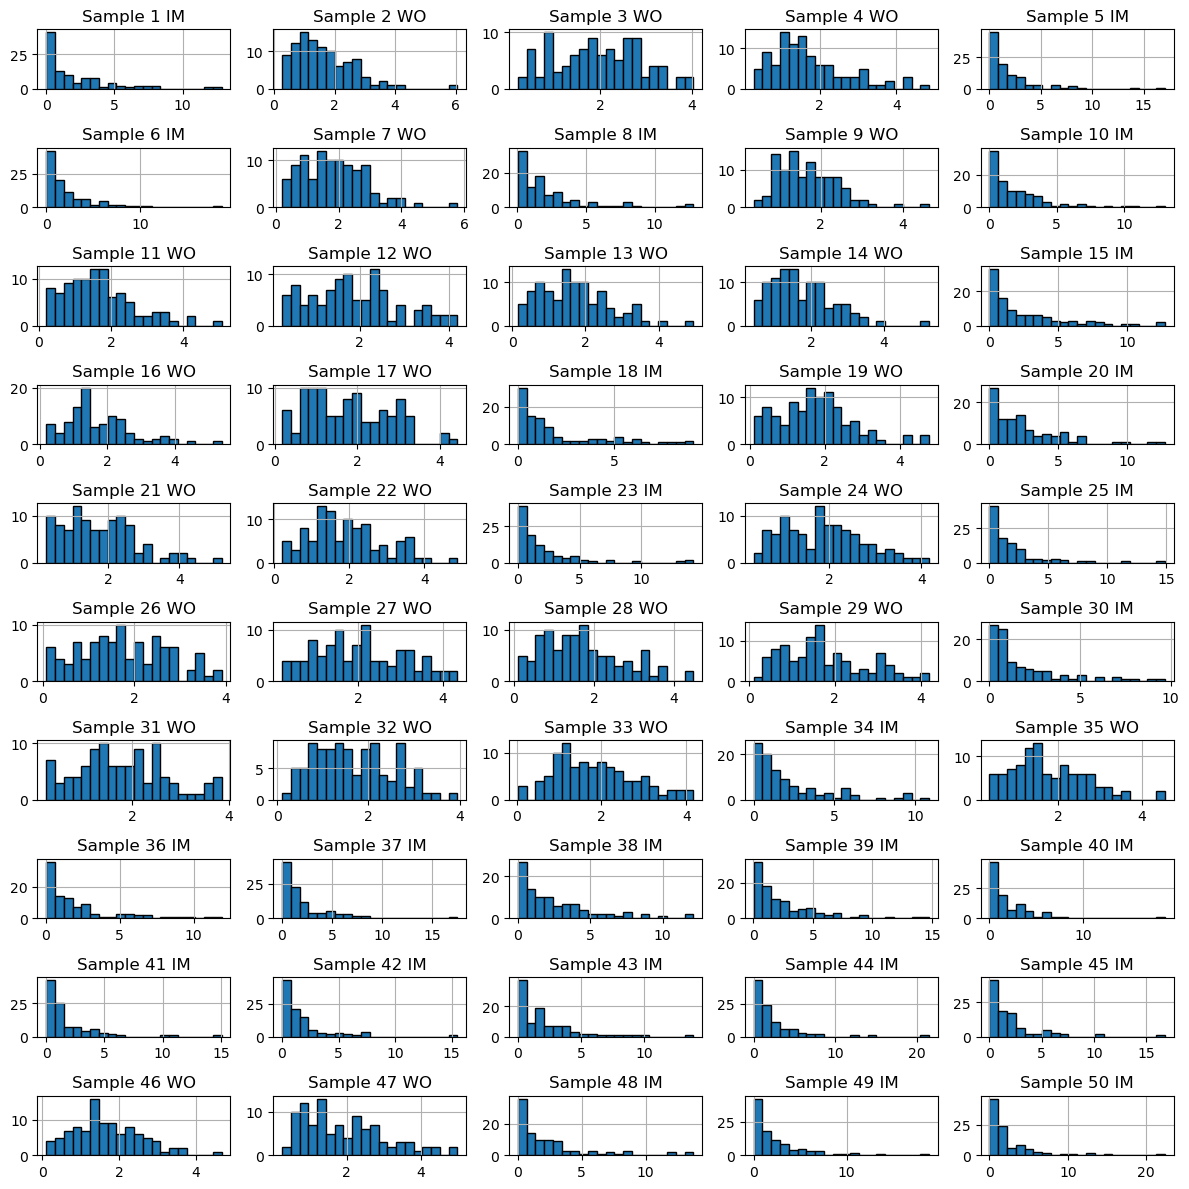

In [6]:
# Select specific rows for visualization (e.g., the 10th sample)
nrow = 10
ncol = 5
fix, axes = plt.subplots(nrow, ncol, figsize=(12,12))
ax_flat = axes.flatten()

for ax, sample_index in zip(ax_flat, list(range(nrow*ncol))): 
    selected_sample = features[sample_index]
    ax.hist(selected_sample, bins=20, edgecolor='black')
    ax.set_title(f'Sample {sample_index+1} {"IM" if labels[sample_index] == 0 else "WO"}')
    ax.grid(True)

plt.tight_layout()
plt.show();


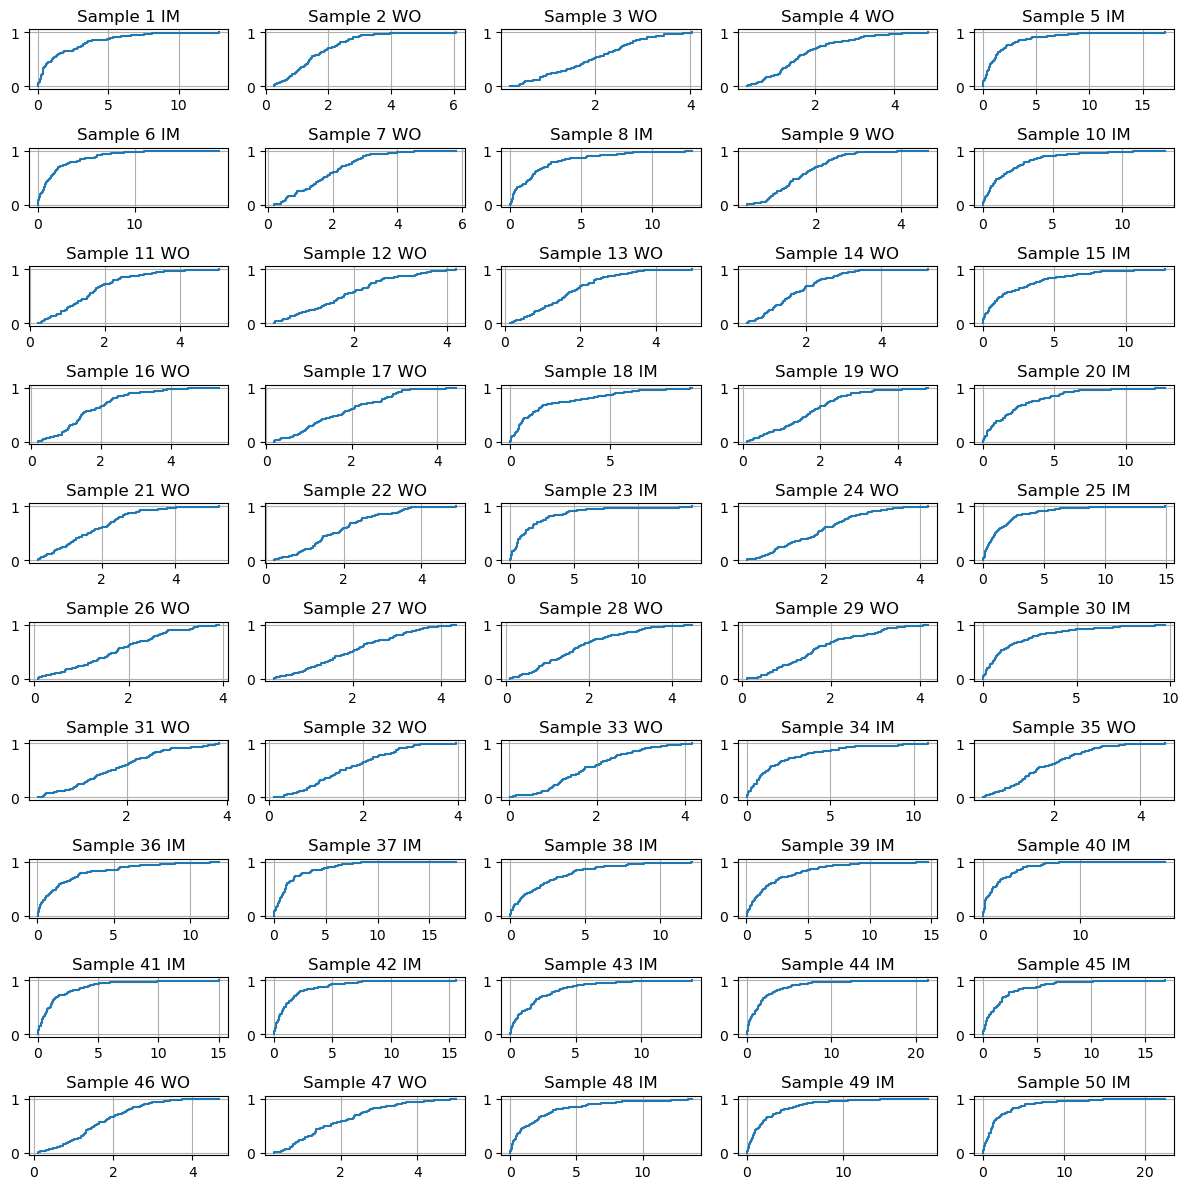

In [7]:
nrow = 10
ncol = 5
fix, axes = plt.subplots(nrow, ncol, figsize=(12,12))
ax_flat = axes.flatten()

for ax, sample_index in zip(ax_flat, list(range(nrow*ncol))): 
    selected_sample = features[sample_index]
    ecdf = ECDF(selected_sample)

    ax.step(ecdf.x, ecdf.y, where='post')
    ax.set_title(f'Sample {sample_index+1} {"IM" if labels[sample_index] == 0 else "WO"}')
    ax.grid(True)

plt.tight_layout()
plt.show();

# Train-test split 

In [8]:
X = df_data.iloc[:, :-2].values
X.shape
type(X)

(1000, 100)

numpy.ndarray

In [9]:
y = df_data.iloc[:, -2:-1].values.squeeze()
y.shape 
type(y)

(1000,)

numpy.ndarray

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2023)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=2023)

X_train.shape
X_valid.shape 
X_test.shape 

y_train.shape
y_valid.shape
y_test.shape


(640, 100)

(160, 100)

(200, 100)

(640,)

(160,)

(200,)

# Models

In [11]:
model_dict = {
    0: LogisticRegression(random_state=11), 
    1: RandomForestClassifier(random_state=11), 
    2: xgb.XGBClassifier(objective="binary:logistic", random_state=11)
}

# Training functions and evaluation functions

In [12]:
def train_model(model_num, X_train=X_train, y_train=y_train, X_valid=X_valid): 
    m = model_dict.get(model_num)
    m.fit(X_train, y_train)
    preds = m.predict(X_valid)
    return preds 

In [13]:
def evaluate_model(y, y_pred, model_desc=''): 
    cr = classification_report(y, y_pred)
    print(cr) 
    
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(f'{model_desc}')
    plt.xlabel("predicted label")
    plt.ylabel("true label")
    plt.plot()
    

In [14]:
def train_eval_pipeline(model_num, X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid): 
    model_desc = model_dict.get(model_num)
    print(f'\n\nmodel: {model_desc}')
    preds_valid = train_model(model_num, X_valid=X_valid)
    evaluate_model(y_valid, preds_valid, model_desc)

# Training and model selection




model: LogisticRegression(random_state=11)
              precision    recall  f1-score   support

         0.0       0.88      0.73      0.80        81
         1.0       0.76      0.90      0.83        79

    accuracy                           0.81       160
   macro avg       0.82      0.81      0.81       160
weighted avg       0.82      0.81      0.81       160



model: RandomForestClassifier(random_state=11)
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99        81
         1.0       0.99      0.99      0.99        79

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None

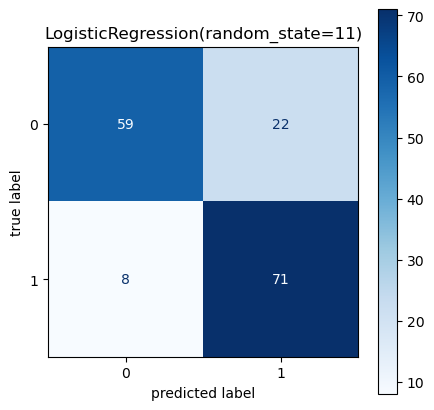

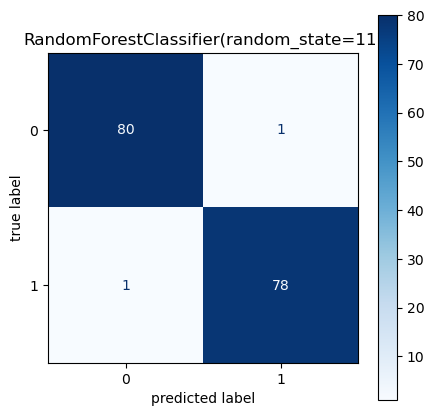

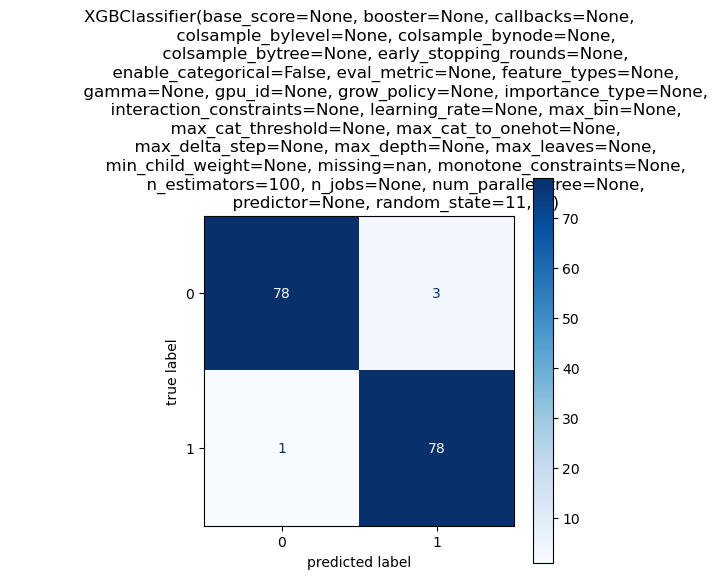

In [15]:
for model in model_dict.keys(): 
    train_eval_pipeline(model)

# Retraining selected model and running inference 

In [16]:
X_train_and_valid = np.concatenate((X_train, X_valid), axis=0)
y_train_and_valid = np.concatenate((y_train, y_valid), axis=0)



model: RandomForestClassifier(random_state=11)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       100
         1.0       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



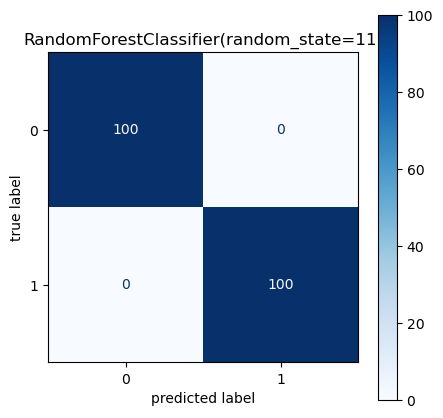

In [17]:
selected_model_num = 1
train_eval_pipeline(selected_model_num, X_train_and_valid, y_train_and_valid, X_test, y_test)